# UIDAI Aadhaar Biometric Failure Risk Analysis

## UIDAI Data Hackathon 2026

### Author: Nidhi Kumawat

---

### 📌 Objective
This project analyzes Aadhaar **Enrollment** and **Biometric Update** datasets
to identify districts where **outdated child biometrics** may cause
future identification failures.

The focus is on:
- Children enrolled at ages **5–17**
- Lack of biometric updates in adulthood
- District-level biometric failure risk


Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


## 📊 Datasets Used

### 1️⃣ Aadhaar Enrollment Dataset
**Columns:**
- `date`
- `state`
- `district`
- `pincode`
- `age_0_5`
- `age_5_17`
- `age_18_greater`

This dataset represents the number of Aadhaar enrollments by age group.

---

### 2️⃣ Aadhaar Biometric Dataset
**Columns:**
- `date`
- `state`
- `district`
- `pincode`
- `bio_age_5_17`
- `bio_age_17_`

This dataset represents biometric update activi-ication problems later in life.


## 📥 Data Loading

The enrollmeic datasetisre loaded from CSV files
and combined to create a unified district-level dataset for analysis.


In [4]:
en1 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_enrolment\api_data_aadhar_enrolment_0_500000.csv")
en2 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_enrolment\api_data_aadhar_enrolment_500000_1000000.csv")
en3 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_enrolment\api_data_aadhar_enrolment_1000000_1006029.csv")

enrol_df = pd.concat([en1, en2, en3], ignore_index=True)
enrol_df.head()


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


## 📥 Data Loading

Thd biometric datasetisre loaded from CSV files
and combined to create a unified district-level dataset for analysis.


In [5]:
b1 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_biometric\api_data_aadhar_biometric_0_500000.csv" )
b2 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_biometric\api_data_aadhar_biometric_500000_1000000.csv" )
b3 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_biometric\api_data_aadhar_biometric_1000000_1500000.csv" )
b4 = pd.read_csv(r"C:\Users\ADMIN\Desktop\UIDAI_Project\Data\api_data_aadhar_biometric\api_data_aadhar_biometric_1500000_1861108.csv" )

bio_df = pd.concat([b1, b2, b3, b4], ignore_index=True)
bio_df.head()


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


## 🧹 Data Cleaning & Aggregation

Steps performed:
- Removed missing and invalid entries
- Aggregated data at **district level**
- Summed age-wise enrollment and biometric counts
- Ensured consistent district and state naming

This ensures accurate comparison across districts.


In [12]:
enrol_dist = enrol_df.groupby(
    ['state', 'district']
).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrolment': 'sum'
}).reset_index()


In [20]:
bio_dist = bio_df.groupby(
    ['state', 'district', 'pincode']
).agg({
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()


In [ ]:

### 🔗 Why Combine These Datasets?
Children enrolled at young ages must update biometrics as they grow.
Failure to do so leads to authentication problems later in life.


In [21]:
df = enrol_dist.merge(
    bio_dist,
    on=['state', 'district'],
    how='left'
)

df[['bio_age_5_17', 'bio_age_17_']] = df[['bio_age_5_17', 'bio_age_17_']].fillna(0)


## 🧠 Feature Engineering

New features create
- **Total Enrollment**
- indicates tatal enrollmentsd:

- **Child Biometric Failure**
  - Estimated as enrolled children (5–17) who have not updated biometrics

- **Adult Biometric Update Ratio**
  - Measures biometric updates among adults

- **Biometric Risk Score**
  - Indicates districts with higher future identification risk


In [23]:
df['total_enrolment'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)

df['total_bio_updates'] = (
    df['bio_age_5_17'] +
    df['bio_age_17_']
)

df['adult_ratio'] = df['age_18_greater'] / df['total_enrolment']
df['bio_failure_risk'] = 1 - (df['total_bio_updates'] / df['total_enrolment'])


In [24]:
df.head()


,state,district,age_0_5,age_5_17,age_18_greater,total_enrolment,pincode,bio_age_5_17,bio_age_17_,total_bio_updates,adult_ratio,bio_failure_risk
0,100000,100000,0,1,217,218,NaN,0.0,0.0,0.0,0.995413,1.000000
1,Andaman & Nicobar Islands,Andamans,70,5,0,75,744101.0,177.0,1147.0,1324.0,0.000000,-16.653333
2,Andaman & Nicobar Islands,Andamans,70,5,0,75,744102.0,0.0,1.0,1.0,0.000000,0.986667
3,Andaman & Nicobar Islands,Andamans,70,5,0,75,744103.0,63.0,152.0,215.0,0.000000,-1.866667
4,Andaman & Nicobar Islands,Andamans,70,5,0,75,744105.0,43.0,157.0,200.0,0.000000,-1.666667


In [26]:


# Total enrolment
df['total_enrolment'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

# Total biometric updates
df['total_bio_updates'] = (
    df['bio_age_5_17'] + df['bio_age_17_']
)

# Child biometric failure
df['child_bio_failed'] = (
    df['age_5_17'] - df['bio_age_5_17']
).clip(lower=0)

df['child_bio_failure_rate'] = (
    df['child_bio_failed'] / df['age_5_17']
).fillna(0)

# Adult biometric update ratio
df['adult_update_ratio'] = (
    df['bio_age_17_'] / df['age_18_greater']
).fillna(0)


## 📈 Univariate Analysis

This section analyzes individual variables such as:
- Enrollment distribution across age groups
- Biometric update distribution
- Child biometric failure counts

These plots help understand overall trends.


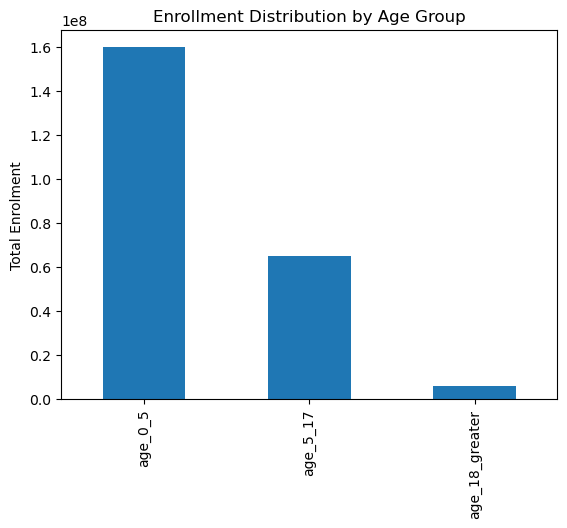

In [27]:


age_sum = df[['age_0_5','age_5_17','age_18_greater']].sum()

age_sum.plot(kind='bar')
plt.title("Enrollment Distribution by Age Group")
plt.ylabel("Total Enrolment")
plt.show()


C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


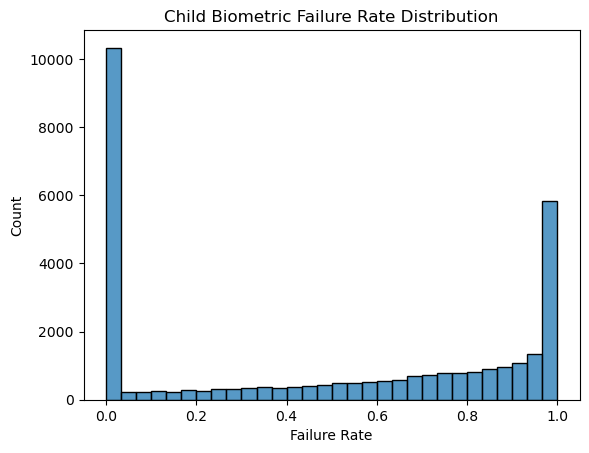

In [28]:
import seaborn as sns

sns.histplot(df['child_bio_failure_rate'], bins=30)
plt.title("Child Biometric Failure Rate Distribution")
plt.xlabel("Failure Rate")
plt.show()


## 🔗 Bivariate Analysis

We analyze relationships between:
- Adult biometric update ratio vs child biometric failure
- Enrollment size vs biometric updates

This helps identify whether adult behavior affects child biometric risk.


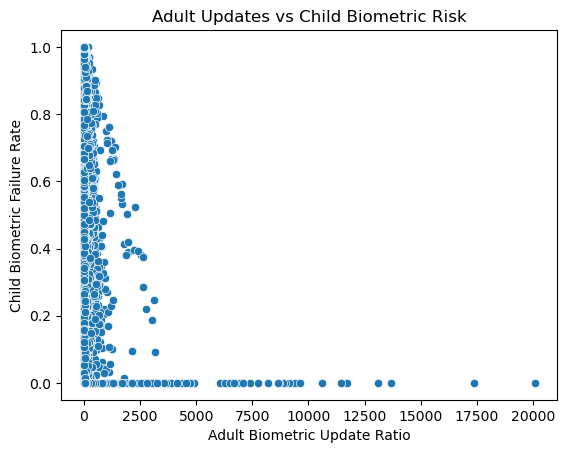

In [29]:
sns.scatterplot(
    x=df['adult_update_ratio'],
    y=df['child_bio_failure_rate']
)
plt.xlabel("Adult Biometric Update Ratio")
plt.ylabel("Child Biometric Failure Rate")
plt.title("Adult Updates vs Child Biometric Risk")
plt.show()


## 🌡 Trivariate Analysis (Heatmap)

A heatmap is used to visualize:
- District-wise biometric failure
- Adult update ratio
- Enrollment size

This reveals regional clusters with high biometric risk.


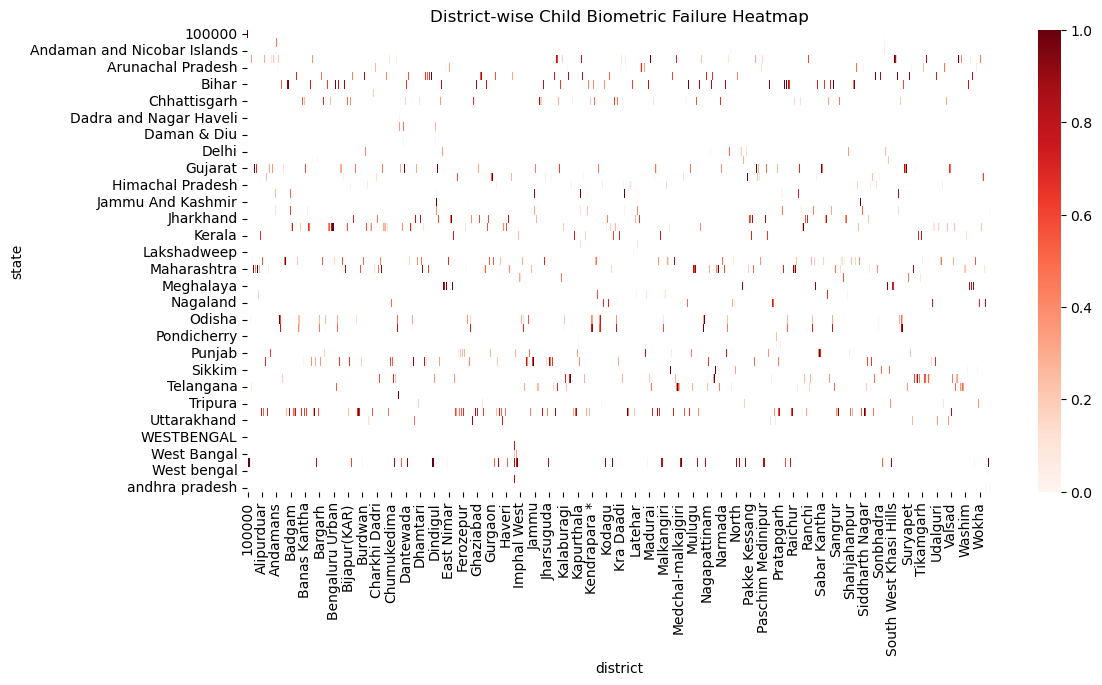

In [31]:
heat_df = df.pivot_table(
    values='child_bio_failure_rate',
    index='state',
    columns='district',
    aggfunc='mean'
)

plt.figure(figsize=(12,6))
sns.heatmap(heat_df, cmap='Reds')
plt.title("District-wise Child Biometric Failure Heatmap")
plt.show()


## 🚨 Anomaly Detection

Z-score based anomaly detection is used to:
- Identify districts with unusually high biometric failure
- Flag regions needing urgent biometric update drives

These districts are marked as **high-risk zones**.


In [33]:
df['failure_zscore'] = (
    (df['child_bio_failure_rate'] - df['child_bio_failure_rate'].mean()) /
    df['child_bio_failure_rate'].std()
)

anomalies = df[df['failure_zscore'] > 3]
anomalies[['state','district','child_bio_failure_rate']]


,state,district,child_bio_failure_rate


## ⭐ Core Insight: Child–Adult Biometric Update Risk

Children enrolled between ages 5–9 often fail to update biometrics.
If adults in a district also show low biometric updates,
the district faces **long-term identification risk**.

This insight can help UIDAI:
- Plan targeted biometric update campaigns
- Improve Aadhaar authentication success rates
- Reduce identity mismatch issues in future


In [35]:
df['risk_category'] = np.where(
    (df['child_bio_failure_rate'] > 0.5) &
    (df['adult_update_ratio'] < 0.3),
    'HIGH RISK',
    'NORMAL'
)

df['risk_category'].value_counts()


risk_category
NORMAL       27151
HIGH RISK     4123
Name: count, dtype: int64

## ✅ Conclusion

- Biometric updates are not uniformly distributed across districts
- Child biometric failure is strongly linked to adult update behavior
- Early intervention can prevent future authentication failures

This analysis demonstrates how open government data
can be used for **policy planning and digital identity improvement**.


## 🔮 Future Scope

- Integration with demographic data
- Predictive modeling for biometric failure
- Real-time district risk dashboard
- Policy-level recommendation system
